<table style="width:99%">
<tr>    
<td style="text-align: center">
<h1>Lab 06: Assignment</h1>
<h2>Arkadiusz Paterak</h2>
</td>
</tr>
</table>

# Introduction

The goal of this notebook is **an extension of the Monte-Carlo advection solver** to **two spatial dimensions (2D)** based on the solver from our 6th laboratory classes.

In [ ]:
"""notebook code targetting 100% `nbqa pylint` score! :)"""

from copy import deepcopy
from dataclasses import dataclass, field
from functools import cached_property

from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
import scipy
from open_atmos_jupyter_utils import show_plot

# Implementation

In [ ]:
@dataclass(frozen=True)
class ParticleParams:
    """
    The parameters associated with the particles distribution.
    """
    n_part: int = 10_000
    norm: float = 1e10
    mean: np.ndarray = field(default_factory=lambda: np.array([250.0, 250.0]))
    cov: np.ndarray = field(
        default_factory=lambda: np.array([[2500.0, 0.0], [0.0, 2500.0]])
    )

    @cached_property
    def dist(self) -> scipy.stats.multivariate_normal:
        """
        Distribution.
        """
        return scipy.stats.multivariate_normal(mean=self.mean, cov=self.cov)

    def one_dim_dist(self, dim: int = 0) -> scipy.stats.norm:
        """
        Returns one dimensional distribution.
        """
        if dim < 0 or dim >= self.mean.shape[0]:
            raise IndexError(
                f"Dimension {dim} out of range for mean vector of length {self.mean.shape[0]}"
            )

        mu = self.mean[dim]
        sigma = np.sqrt(self.cov[dim, dim])
        return scipy.stats.norm(loc=mu, scale=sigma)

    def ppf(self, q: float, dim: int = 0) -> float:
        """
        Calculates ppf for one dimension.
        """
        return self.one_dim_dist(dim).ppf(q)

@dataclass
class GridParams:
    """
    The parameters associated with the spatial grid.
    """
    span: np.ndarray = field(default_factory=lambda: np.array([1000, 1000]))
    n_cell: np.ndarray = field(default_factory=lambda: np.array([50, 50]))

    @cached_property
    def step(self) -> np.ndarray:
        """
        Step.
        """
        return np.array(self.span) / np.array(self.n_cell)

@dataclass(frozen=True)
class TimeParams:
    """
    The parameters associated with the time.
    """
    span: float = 300
    n_step: int = 30
    wind: np.ndarray = field(default_factory=lambda: np.array([1.5, -0.5]))

    @cached_property
    def step(self) -> np.ndarray:
        """
        Step.
        """
        return np.array(self.span) / np.array(self.n_step)

def calculate_courant_number(
    params_t: TimeParams,
    params_xy: GridParams,
) -> np.ndarray:
    """Calculates the Courant number based on wind, grid and time step."""
    return params_t.wind / params_xy.step * params_t.step

PARAMS_P = ParticleParams()
PARAMS_XY = GridParams()
PARAMS_T = TimeParams()
COURANT_NUMBER = calculate_courant_number(PARAMS_T, PARAMS_XY)

RNG = np.random.default_rng(seed=44)

In [ ]:
@dataclass
class Particles:
    """
    A state of particles.
    """
    cell: np.ndarray = field(default_factory=lambda: np.zeros((0, 2), dtype=int))
    mult: np.ndarray = field(default_factory=lambda: np.zeros(0, dtype=int))
    xy: np.ndarray = field(default_factory=lambda: np.zeros((0, 2), dtype=float))

def sample(
    *,
    params_p: ParticleParams,
    params_xy: GridParams,
    rng: np.random.Generator,
) -> dict[str, Particles]:
    """
    Samples a particle population specified onto a 2D grid for two sampling strategies.
    """
    u01 = rng.uniform(low=0.0, high=1.0, size=(params_p.n_part, 2))

    xy_ppf = np.column_stack(
        [
            params_p.ppf(u01[:, 0], dim=0),
            params_p.ppf(u01[:, 1], dim=1),
        ]
    )

    return {
        strategy: Particles(
            cell=np.floor(v["xy"] / params_xy.step).astype(int),
            mult=np.round(v["mult"] * params_p.norm).astype(int),
            xy=v["xy"],
        )
        for strategy, v in {
            "sampling: uniform random in x and y": {
                "xy": u01 * params_xy.span,
                "mult": params_p.dist.pdf(u01 * params_xy.span)
                * (params_xy.span[0] * params_xy.span[1] / params_p.n_part),
            },
            "sampling: constant multiplicity": {
                "xy": xy_ppf,
                "mult": np.full(params_p.n_part, 1 / params_p.n_part),
            },
        }.items()
    }

PARTICLES_BY_STRATEGY = sample(params_p=PARAMS_P, params_xy=PARAMS_XY, rng=RNG)

In [ ]:
def advect(
    particles: Particles,
    *,
    params_p: ParticleParams,
    params_t: TimeParams,
    courant_number: tuple[float, float],
    rng: np.random.Generator,
) -> Particles:
    """
    Performs Monte-Carlo advection of the particles in 2D.
    """
    probability_of_shift = [abs(c) for c in courant_number]
    assert all(p < 1 for p in probability_of_shift)

    direction = [np.sign(c) for c in courant_number]

    p = deepcopy(particles)

    for _ in range(params_t.n_step):
        u01 = rng.uniform(low=0.0, high=1.0, size=(params_p.n_part, 2))

        p.cell += ((u01 < probability_of_shift) * direction).astype(int)

    return p

PARTICLES_AFTER_ADVECTION = {
    s: advect(
        p,
        params_t=PARAMS_T,
        params_p=PARAMS_P,
        courant_number=COURANT_NUMBER,
        rng=RNG,
    )
    for s, p in PARTICLES_BY_STRATEGY.items()
}

# Results

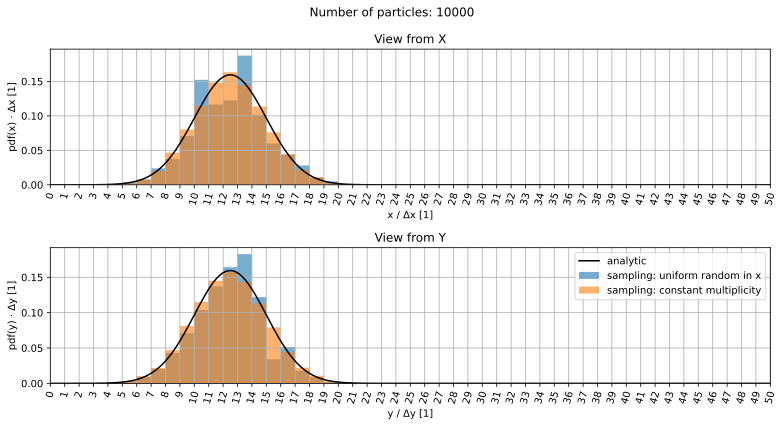

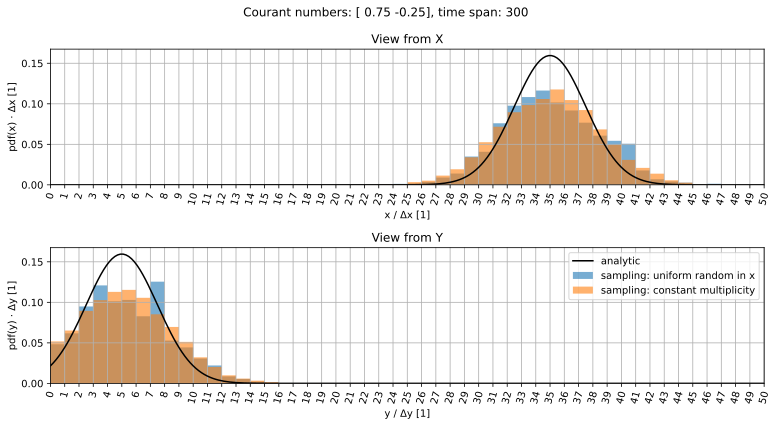

In [ ]:
def plot_histograms_from_views(particles_by_strategy, shift=(0, 0), *, title=None):
    """
    Plots histograms from two views.
    """
    fig, axs = plt.subplots(2, 1, figsize=(11, 6))

    if title:
        fig.suptitle(title)

    axs[0].set_title("View from X")
    axs[0].set_xlabel("x / Δx [1]")
    axs[0].set_ylabel("pdf(x) ⋅ Δx [1]")

    axs[1].set_title("View from Y")
    axs[1].set_xlabel("y / Δy [1]")
    axs[1].set_ylabel("pdf(y) ⋅ Δy [1]")

    for i, ax in enumerate(axs):
        dim = np.linspace(0, PARAMS_XY.span[i], 256)
        ax.plot(
            dim / PARAMS_XY.step[i],
            PARAMS_P.one_dim_dist(i).pdf(dim - shift[i]) * PARAMS_XY.step[i],
            color="black",
            label="analytic",
        )
        for strategy, particles in particles_by_strategy.items():
            ax.hist(
                x=particles.cell[:, i],
                bins=PARAMS_XY.n_cell[i],
                weights=particles.mult / PARAMS_P.norm,
                alpha=0.6,
                label=strategy,
                range=(0, PARAMS_XY.n_cell[i]),
            )

        ax.set_xticks(np.arange(0, PARAMS_XY.n_cell[i] + 1))
        ax.xaxis.set_tick_params(rotation=75)
        ax.grid()
        ax.set_xlim(0, PARAMS_XY.n_cell[i])

    plt.tight_layout()
    plt.legend()
    show_plot()

plot_histograms_from_views(
    PARTICLES_BY_STRATEGY, title=f"Number of particles: {PARAMS_P.n_part}"
)
plot_histograms_from_views(
    PARTICLES_AFTER_ADVECTION,
    shift=PARAMS_T.wind * PARAMS_T.span,
    title=f"Courant numbers: {COURANT_NUMBER}, time span: {PARAMS_T.span}",
)

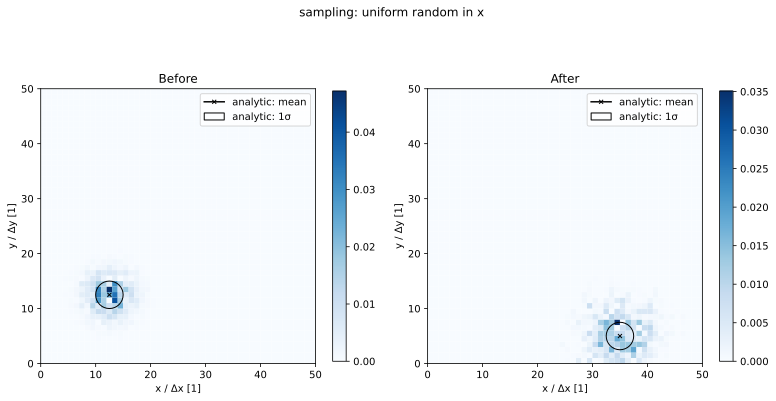

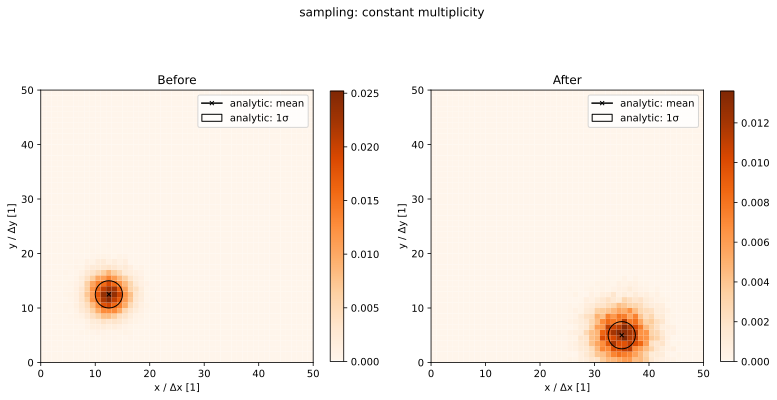

In [ ]:
def plot_2d_histograms():
    """
    Plots 2D histograms.
    """
    for strategy in PARTICLES_BY_STRATEGY.keys():
        fig, axs = plt.subplots(1, 2, figsize=(11, 6))

        plt.suptitle(f"{strategy}")

        dist_x = PARAMS_P.one_dim_dist(0)
        dist_y = PARAMS_P.one_dim_dist(1)

        for i, (particles, shift) in enumerate(
            zip(
                [PARTICLES_BY_STRATEGY[strategy], PARTICLES_AFTER_ADVECTION[strategy]],
                [(0, 0), PARAMS_T.wind * PARAMS_T.span],
            )
        ):
            mean = np.array([dist_x.mean(), dist_y.mean()]) + shift
            std = np.array([dist_x.std(), dist_y.std()])

            mean_idx = mean / PARAMS_XY.step
            std_idx = std / PARAMS_XY.step

            ax = axs[i]
            ax.set_title("Before" if i == 0 else "After")
            ax.set_xlabel("x / Δx [1]")
            ax.set_ylabel("y / Δy [1]")

            hist = ax.hist2d(
                particles.cell[:, 0],
                particles.cell[:, 1],
                weights=particles.mult / PARAMS_P.norm,
                bins=PARAMS_XY.n_cell,
                range=[[0, PARAMS_XY.n_cell[0]], [0, PARAMS_XY.n_cell[1]]],
                cmap="Blues" if not "multiplicity" in strategy else "Oranges",
            )
            _ = fig.colorbar(hist[3], ax=ax, shrink=0.7)

            ax.plot(*mean_idx, marker="x", color="black", ms=4, label="analytic: mean")
            ellipse = patches.Ellipse(
                xy=mean_idx,
                width=2 * std_idx[0],
                height=2 * std_idx[1],
                edgecolor="black",
                facecolor="none",
                lw=1,
                label="analytic: 1σ",
            )
            ax.add_patch(ellipse)

            ax.legend()
            ax.set_aspect("equal")

        plt.tight_layout()
        show_plot()

plot_2d_histograms()

# Conclusions

The particles sampled with constant multiplicity seems to be less dispersed after the advection than when the strategy of sampling uniformly in x and y is used.